# Nicolas Ducros, A Lorente Mur, F. Peyrin. 'A Completion Network for Reconstruction from Compressed Acquisition.' 

2020 IEEE 17th International Symposium on Biomedical Imaging (ISBI), Apr 2020, Iowa City, United States. pp.619-623.
[⟨10.1109/ISBI45749.2020.9098390⟩](https://dx.doi.org/10.1109/ISBI45749.2020.9098390)
[⟨hal-02342766v2⟩](https://hal.archives-ouvertes.fr/hal-02342766v2/document)


##  Imports

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import imageio
import cv2
import fht
import matplotlib.pyplot as plt
import scipy.io as sio
import PIL
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import wget
import zipfile
from pathlib import Path

## Import important functions from spyrit

In [2]:
from spyrit.learning.model_Had_DCAN import *# compNet, Stat_had, Weight_Decay_Loss
from spyrit.learning.nets import *
from spyrit.misc.disp import *
from spyrit.misc.metrics import *


## User-defined global parameters 

In [3]:
#- Acquisition
img_size = 64 # image size
M = 333       # number of neasurements
#- Training
num_epochs = 60
lr = 1e-3 
step_size = 20
gamma = 0.2
batch_size =256
reg = 1e-7
#- Model and data paths
model_root = Path('./models/')
stats_root = Path('./stats/')
data_root = Path('./data/')
#- Save plot using type 1 font
plt.rcParams['pdf.fonttype'] = 42

print(model_root)
print(data_root)

models
data


## Download models and covariance 

In [4]:
if not(Path('./models/').exists()):
    wget.download('https://www.creatis.insa-lyon.fr/~ducros/spyritexamples/2020_ISBI_CNet/2020_ISBI_CNet.zip')
    with zipfile.ZipFile('2020_ISBI_CNet.zip', 'r') as zip_ref:
        zip_ref.extractall()
    Path('2020_ISBI_CNet.zip').unlink()

## Load STL-10 dataset

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])


trainset = \
    torchvision.datasets.STL10(root=data_root, split='train+unlabeled',download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=True, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train':trainloader, 'val':testloader}

Files already downloaded and verified
Files already downloaded and verified


 ## Load trained networks

In [7]:
print('Loading Cov and Mean')    
Cov_had = np.load(stats_root / "Cov_{}x{}.npy".format(img_size, img_size))
Mean_had = np.load(stats_root / 'Average_{}x{}.npy'.format(img_size, img_size))

Loading Cov and Mean


### Statistical completion

In [8]:
suffix = '_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
         img_size, M, num_epochs, lr, step_size, gamma, batch_size, reg)


model = compNet(img_size,M, Mean_had,Cov_had)
model = model.to(device)
title = model_root/('NET_c0mp'+ suffix)
load_net(title, model)

psnr_net_prob, psnr_prob = dataset_psnr(dataloaders['val'], model, device);
     
print_mean_std(psnr_net_prob,'compNet: ')
print_mean_std(psnr_prob,'comp: ')

print('Number of trainable parameters: {}'.format(count_trainable_param(model)))
print('Total number of parameters: {}'.format(count_param(model)))

Measurement to image domain: statistical completion (no mean)
Model Loaded: models/NET_c0mp_N_64_M_333_epo_60_lr_0.001_sss_20_sdr_0.2_bs_256_reg_1e-07
compNet: psnr = 24.071043559813997 +/- 2.30446040775503
comp: psnr = 23.54344088733588 +/- 2.243735738233811
Number of trainable parameters: 8129
Total number of parameters: 7050746


### Pseudo Inverse

In [9]:
model = compNet(img_size,M, Mean_had,Cov_had,2)
model = model.to(device)
title = model_root/('NET_pinv'+ suffix)
load_net(title, model)

psnr_net_pinv, psnr_pinv = dataset_psnr(dataloaders['val'], model, device)

print_mean_std(psnr_net_pinv,'pinvNet: ')
print_mean_std(psnr_pinv,'PInv: ')
print('Number of trainable parameters: {}'.format(count_trainable_param(model)))
print('Total number of parameters: {}'.format(count_param(model)))

Measurement to image domain: pseudo inverse
Model Loaded: models/NET_pinv_N_64_M_333_epo_60_lr_0.001_sss_20_sdr_0.2_bs_256_reg_1e-07
pinvNet: psnr = 23.604518040400016 +/- 2.201547108262377
PInv: psnr = 22.001534603278962 +/- 2.1580386698134015
Number of trainable parameters: 8129
Total number of parameters: 5686778


### Fully learnt (free Net)

In [10]:
model = compNet(img_size,M, Mean_had,Cov_had,3)
model = model.to(device)
title = model_root/('NET_free'+ suffix)
load_net(title, model)
#    
psnr_net_free, psnr_free = dataset_psnr(dataloaders['val'], model, device)

print_mean_std(psnr_net_free,'freeNet: ')
print_mean_std(psnr_free,'free: ')

print('Number of trainable parameters: {}'.format(count_trainable_param(model)))
print('Total number of parameters: {}'.format(count_param(model)))

Measurement to image domain: free
Model Loaded: models/NET_free_N_64_M_333_epo_60_lr_0.001_sss_20_sdr_0.2_bs_256_reg_1e-07
freeNet: psnr = 23.95126987239797 +/- 2.209321473388731
free: psnr = -24.59815287899478 +/- 2.1791864451841123
Number of trainable parameters: 1376193
Total number of parameters: 7054842


### Summary: PSNR boxplot (Fig. 3)

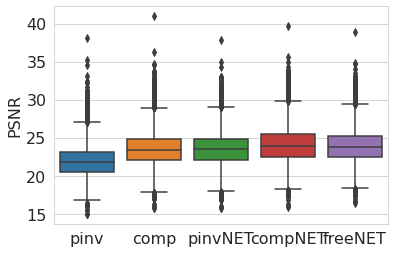

In [11]:
plt.rcParams.update({'font.size': 16})
plt.figure()
sns.set_style("whitegrid")
ax = sns.boxplot(data=pd.DataFrame([psnr_pinv, psnr_prob, psnr_net_pinv, psnr_net_prob, psnr_net_free]).T)
ax.set_xticklabels(['pinv', 'comp', 'pinvNET', 'compNET', 'freeNET']);
ax.set_ylabel('PSNR');
#plt.savefig("boxplot_sns.pdf")

## Measurement scatter plot (Fig. 2)     /!\  not exactely the same as in the manuscript

/home/lorente/Documents/CodesThese/testing_Spyrit/spyrit-env/lib64/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


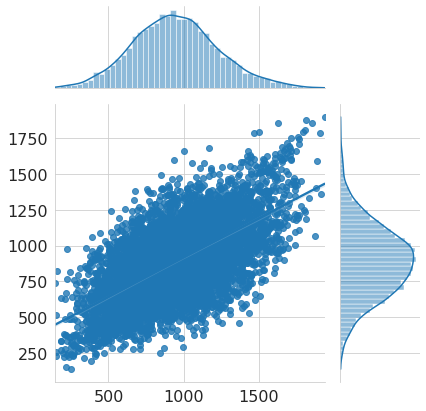

In [12]:
#%% Load measured data
meas = dataset_meas(dataloaders['val'], model, device) #dataloaders['train']
meas = np.array(meas)

#%%
n1 = 2; #2,12 or 2,7
n2 = 7;

sns.jointplot(meas[:,n1], meas[:,n2], kind='reg', ratio=3)#, xlim=[-2,2], ylim=[-5, 5])
plt.xlabel('Hadamard coefficient #{}'.format(n1))
plt.ylabel('Hadamard coefficient #{}'.format(n2))
plt.show()

## Loss during training (Fig. 4)  /!\ freeNet not exactely the same as in the manuscript¶

In [13]:
# Load training history
train_path = model_root/('TRAIN_c0mp'+suffix+'.pkl')
train_net_prob = read_param(train_path)
train_path = model_root/('TRAIN_pinv'+suffix+'.pkl')
train_net_pinv = read_param(train_path)
train_path = model_root/('TRAIN_free'+suffix+'.pkl')
train_net_free = read_param(train_path)

plt.rcParams.update({'font.size': 20})

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Time (epochs)')
ax.set_ylabel('Loss (MSE)')
ax.plot(train_net_pinv.val_loss,'g--', linewidth=4)
ax.plot(train_net_prob.val_loss,'r-.', linewidth=4)
ax.plot(train_net_free.val_loss,'m', linewidth=4)
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black')
plt.grid(True)
ax.legend(('pinvNET', 'compNET', 'freeNET'),  loc='upper right')
#fig.savefig('loss_test.pdf', dpi=fig.dpi, bbox_inches='tight')# pad_inches=0.1)

ModuleNotFoundError: No module named 'function'